# EDA and Baseline Model for Hit-Predict Project

Resume what we did in the preprocessing notebook...

## Importing Libraries

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.stats import zscore

## Loading and Exploring Data

In [55]:
DATA_PATH = "../data/processed_spotify_songs.csv"
df = pd.read_csv(DATA_PATH)

## Exploratory Data Analysis and Visualization

### Exploration of Variables

Stuff to do from previous hws (add more from labs?):

Identify all variables in the dataset. For each variable, state whether you consider it to be quantitative or categorical and briefly justify your choices. 

The goal in this section is to identify the best feature to use to predict our response, `Current_Selling_Price`. 

- Plot a scatter plot of each feature and our reponse and examine any relationships.
- Which is the predictor that seems to best predict `Current_Selling_Price`? Provide an interpretation of the plots that justifies your choice.

### Distribution of Target Variable (Popularity)

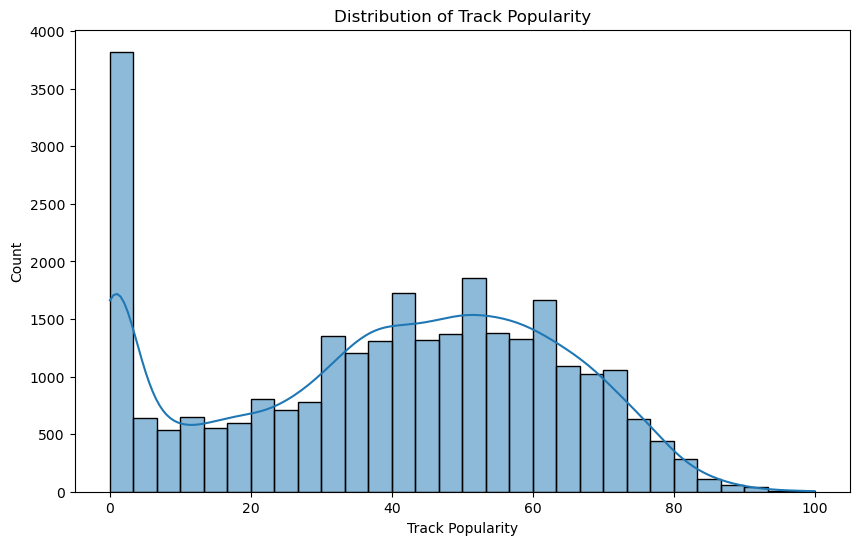

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(df["track_popularity"], bins=30, kde=True)
plt.title("Distribution of Track Popularity")
plt.xlabel("Track Popularity")
plt.ylabel("Count")
plt.show()

#### Dealing with the 0 values in the target variable
a. Replacing 0 values with the artist popularity value (which is the mean popularity of all the songs of that artist)

b. Removing the rows with 0 popularity

c. Not doing anything

### Distribution of the other Variables

Let's plot the distribution of the normalized data

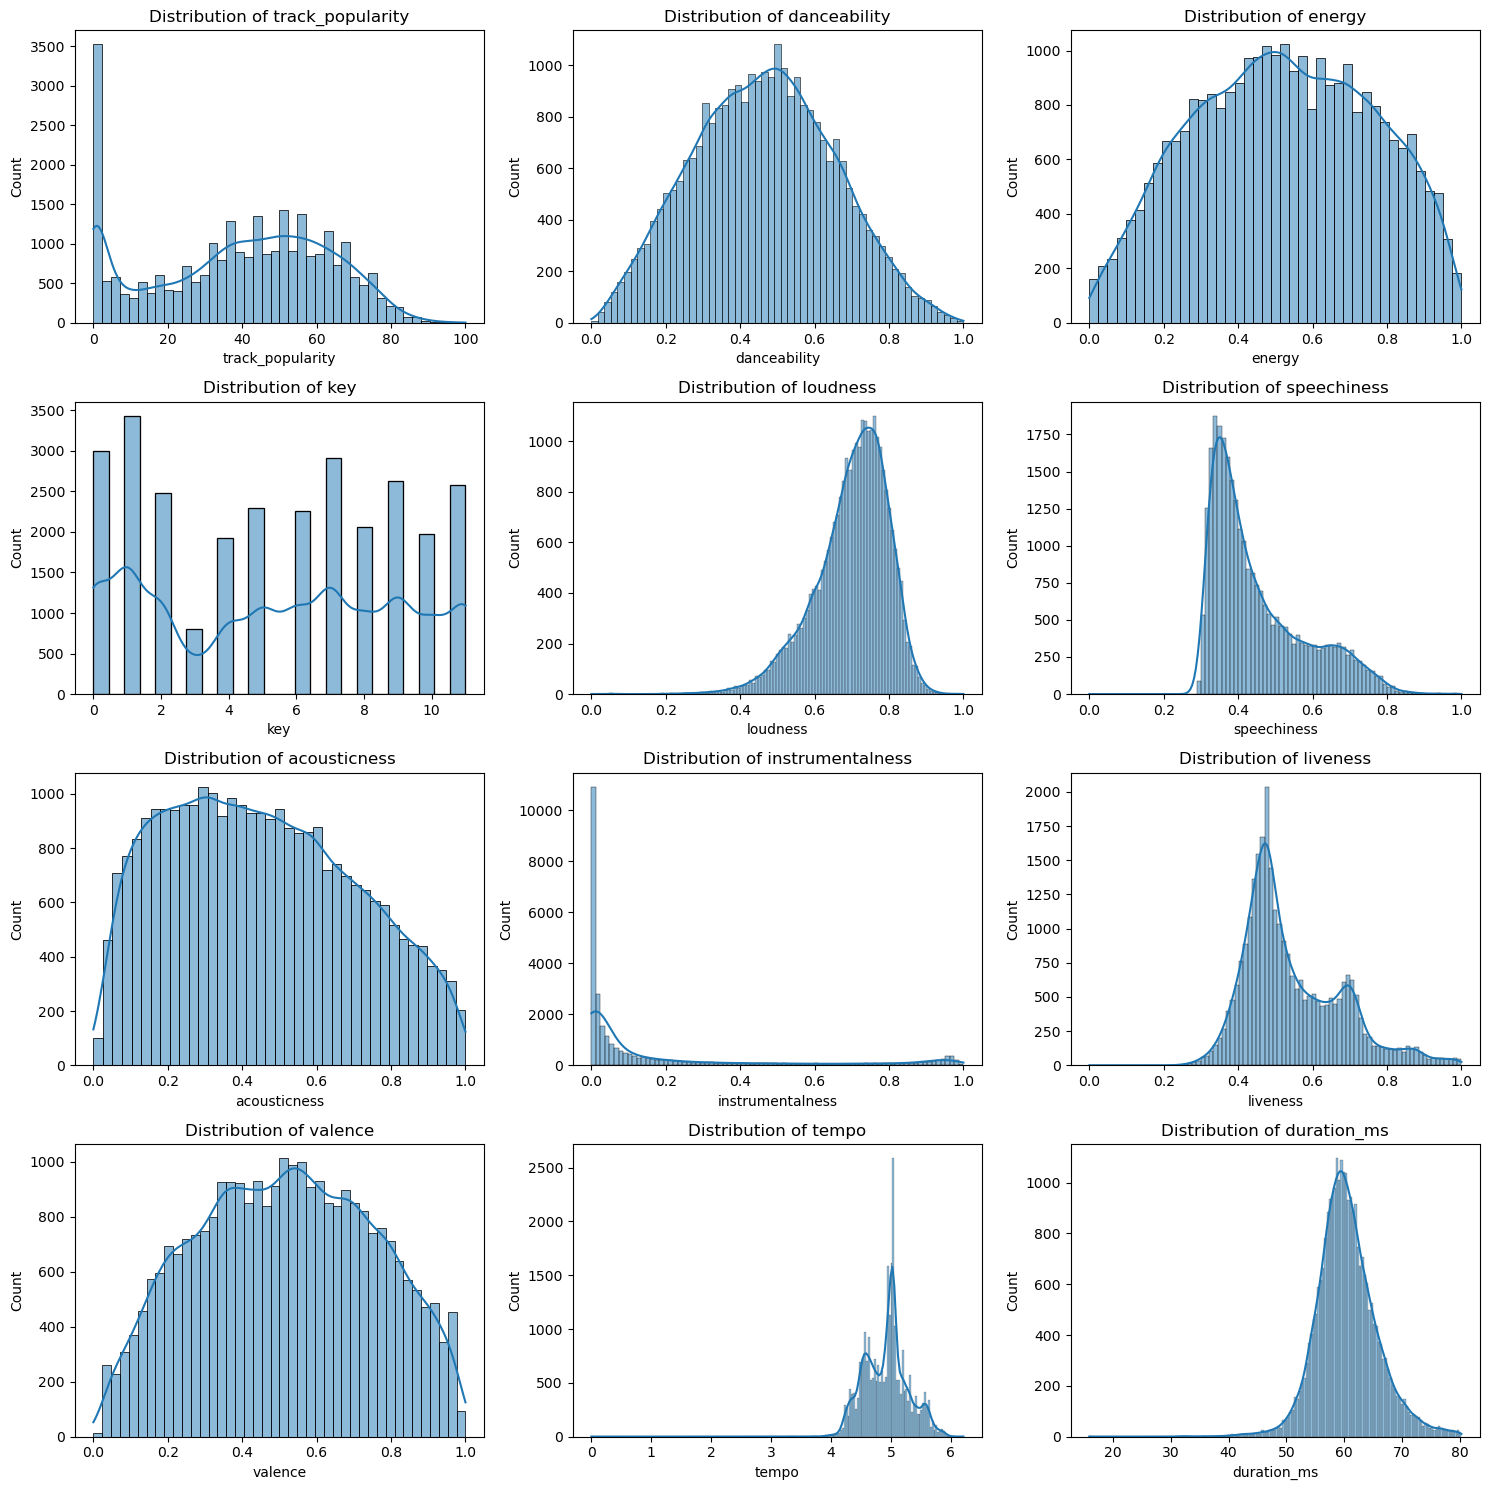

In [57]:
numeric_columns = [
    "track_popularity", "danceability", "energy", "key", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]

plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

#### Comment on those plot

Let's do the same thing for categorical column - track genre.

/var/folders/fk/y4nzg4p56g3_1th0bv19rx0r0000gn/T/ipykernel_82914/465088290.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_counts, x='Genre', y='Count',palette="viridis")


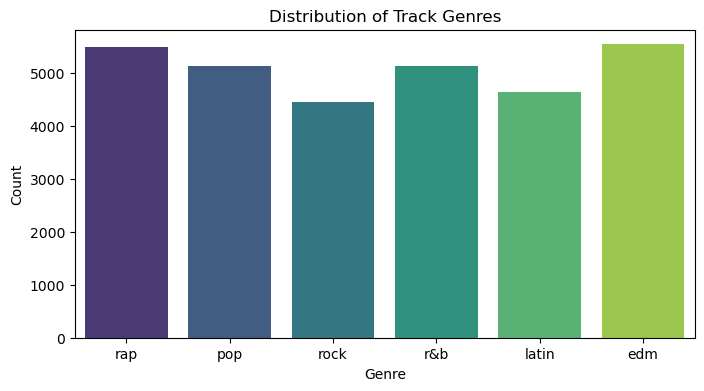

In [58]:
genre_columns = ["rap", "pop", "rock", "r&b", "latin", "edm"]
genre_data = df[genre_columns]

# Sum the occurrences of each genre
genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']  # Renaming columns for clarity

# Plot with Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(data=genre_counts, x='Genre', y='Count',palette="viridis")
plt.title("Distribution of Track Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

There are no outliers for genre track, almost every genre is well-represented among the dataset

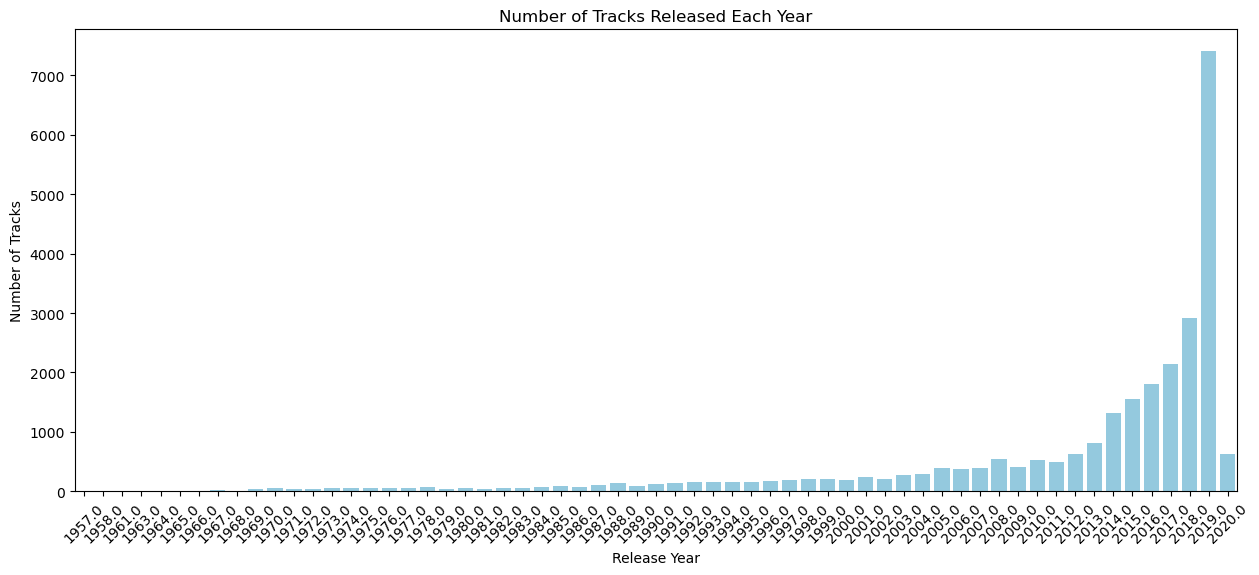

In [92]:
tracks_per_year = df['release_year'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=tracks_per_year.index, y=tracks_per_year.values, color="skyblue")
plt.title("Number of Tracks Released Each Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Tracks")
plt.xticks(rotation=45)  # Rotate x-axis labels if there are many years
plt.show()

We can clearly see that the data is imbalanced for release year, but it's actually a good thing to have more data for recent track since they capture the current trend so that we can predict track_popularity for future hits more accurately

Lastly, let focus on the time-based distribution

### Plotting the different potential predictors against the target variable

As before, let's start plot the different relation from the quantitative predictors with the target variable

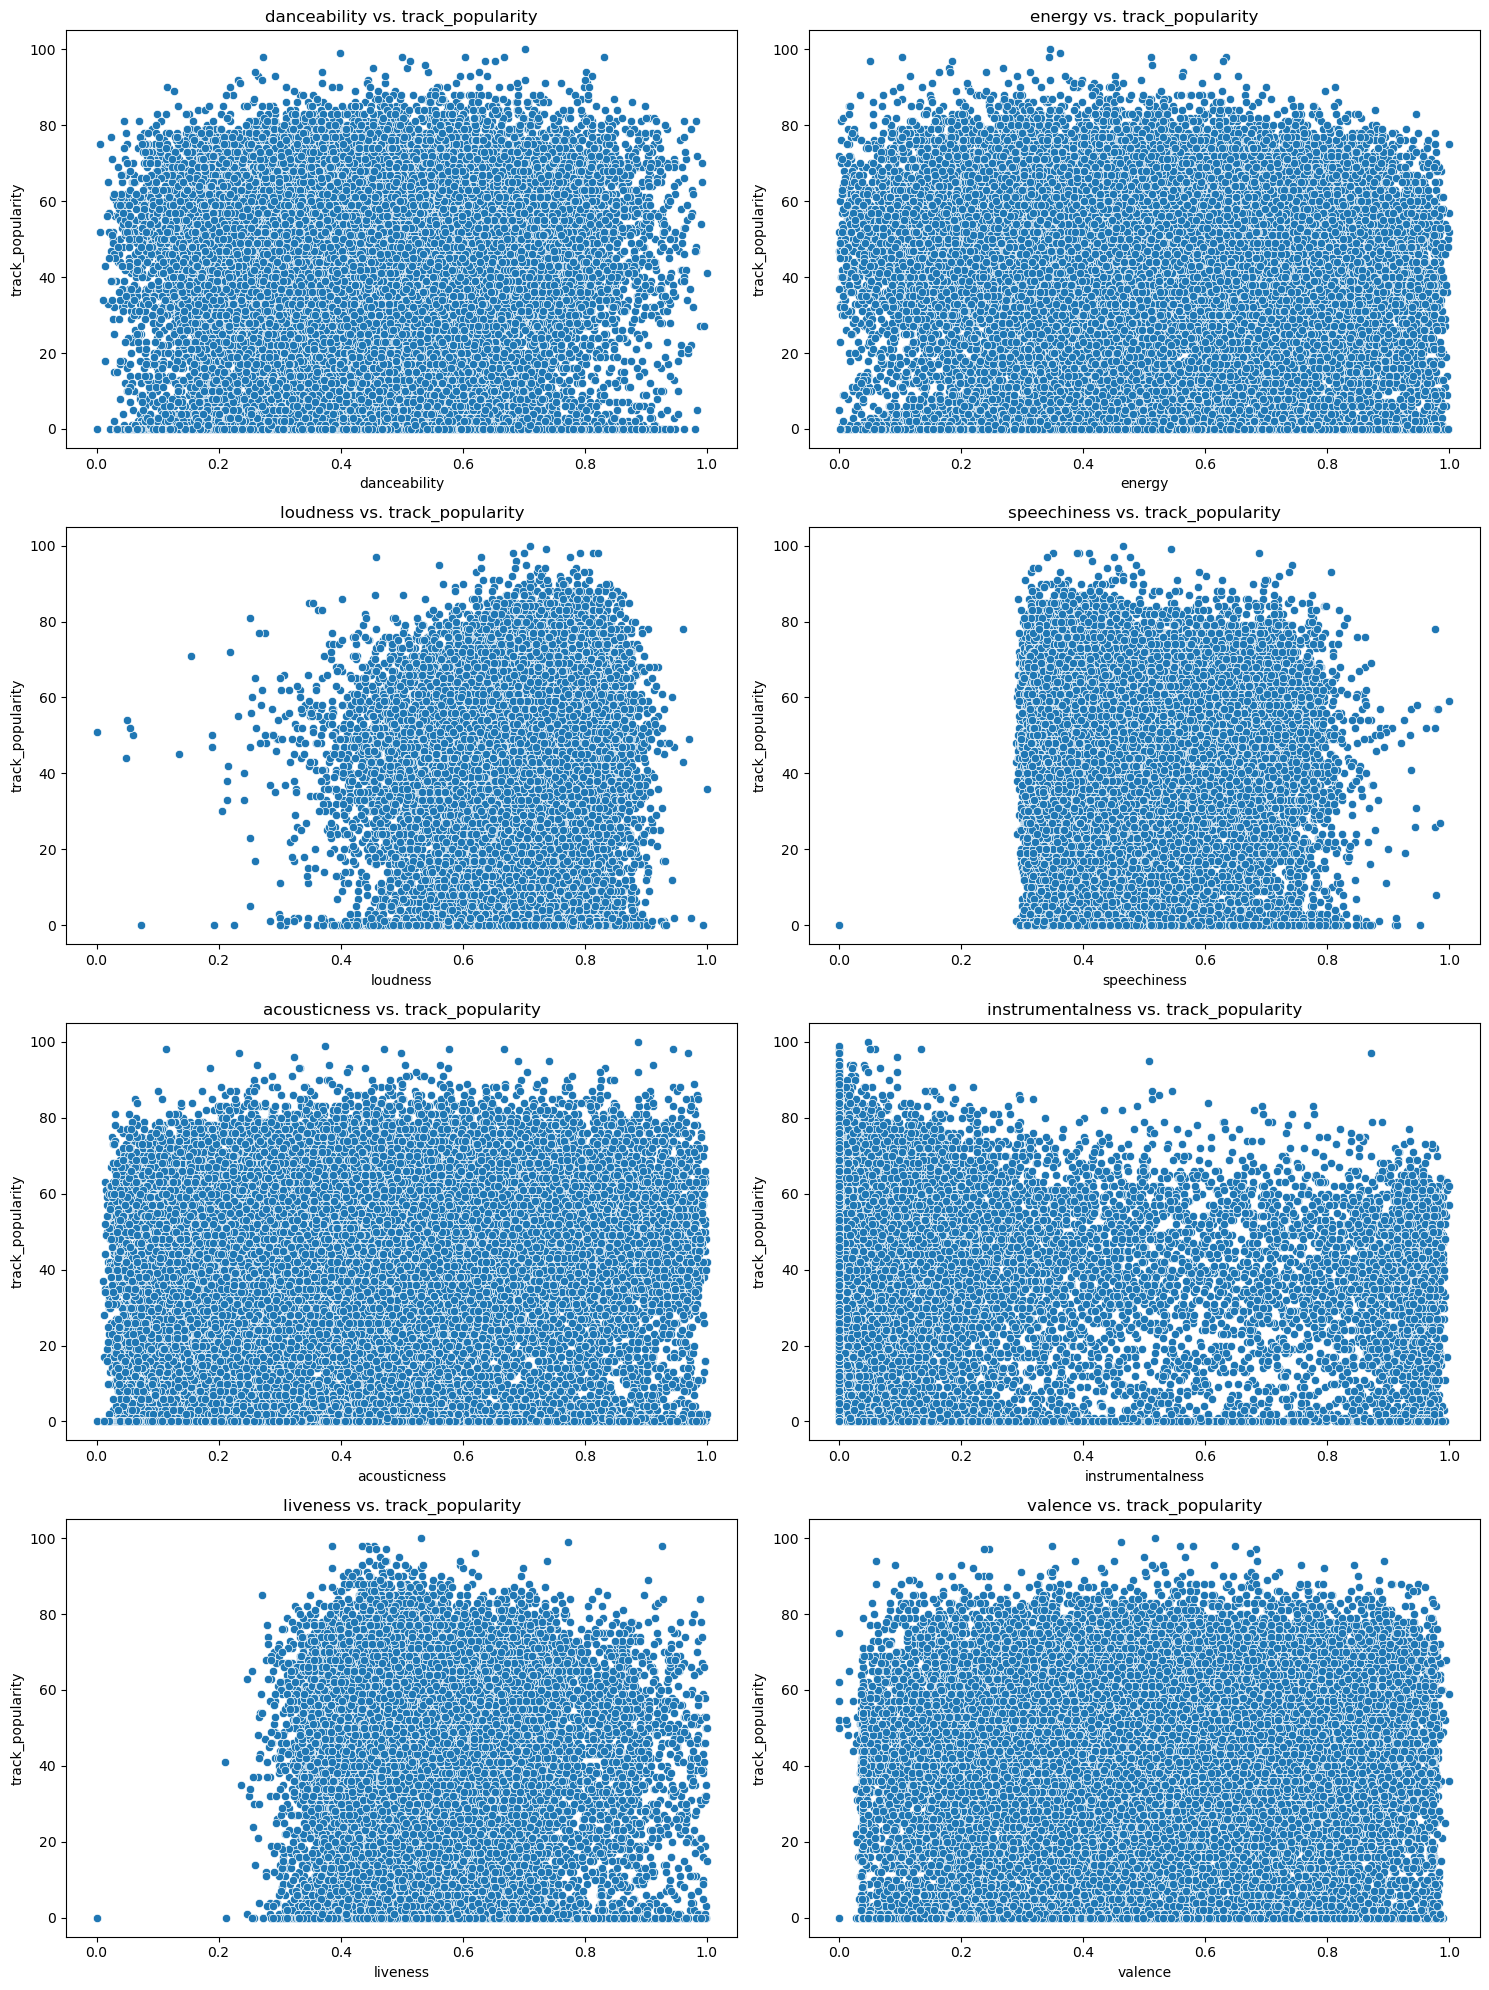

In [59]:

# Create scatter plots for each quantitative predictor vs. track_popularity
plt.figure(figsize=(15, 20))
for i, column in enumerate(column_distribution, 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(data=df, x=column, y="track_popularity")
    plt.title(f"{column} vs. track_popularity")

plt.tight_layout()
plt.show()


From this plots, we can see that there are no apparent relationship from quantitative predictors with the target variable. But what about the categorical variable ?

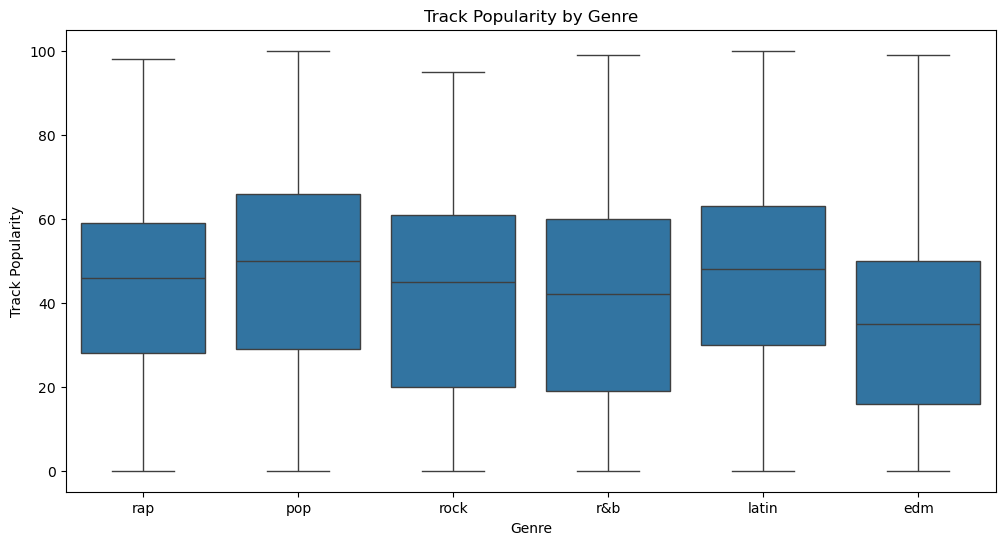

In [60]:
data_melted = df.melt(id_vars=["track_popularity"], value_vars=genre_columns, 
                        var_name="Genre", value_name="Is_Present")

# Filter to only include rows where the genre is present (Is_Present == 1)
data_genre = data_melted[data_melted["Is_Present"] == 1]

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_genre, x="Genre", y="track_popularity")
plt.title("Track Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Track Popularity")
plt.show()

Same conclusion for the genre : there are no clear genre that is more popular than others

In [62]:
# # sns.pairplot(df, vars=numeric_columns, hue="track_popularity", palette="coolwarm")
# plt.suptitle("Pair Plot of Quantitative Features and Track Popularity", y=1.02)
# plt.show()

# Skip this as it takes 4 minutes to run

**Clustering**

Let's start to find the best number of cluster for our data by applying the Silhouettte Score, which measures how similar each point is to its own cluster compared to other clusters.

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-p

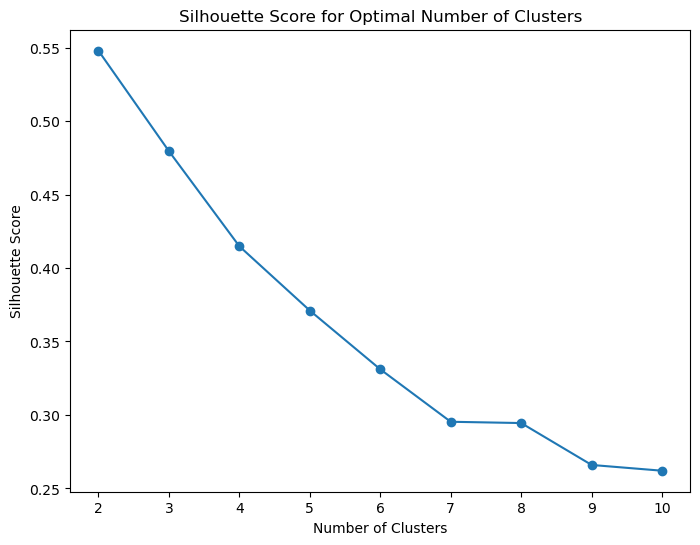

In [63]:
# Selecting key features for clustering
features_for_clustering = df[numeric_columns].fillna(0)

# Test silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_for_clustering)
    silhouette_scores.append(silhouette_score(features_for_clustering, labels))

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()


The best number of clusters is the one that maximize the silhouette score, so here **k = 2**

We do the same thing to find the best number of PCA components, using the Explained Variance Ratio method, where we check the cumulative explained variance to see how much information is retained with each additional component, let use as a treshold 95%.

We will choose the smallest number of components that capture at least 95% of the variance

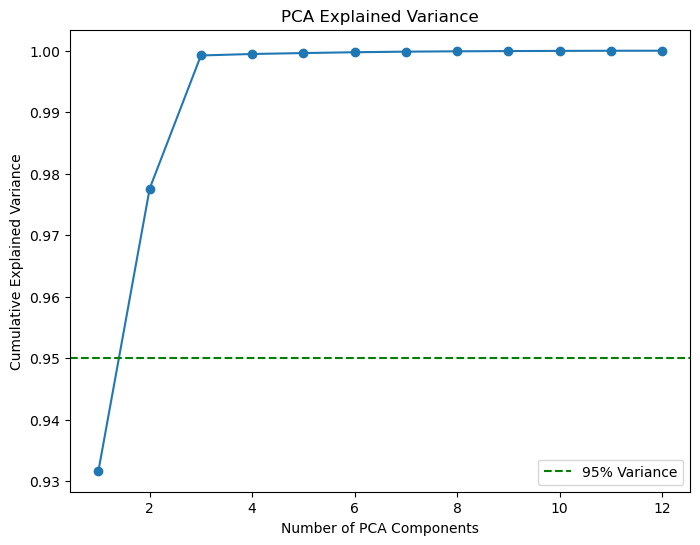

In [64]:
pca = PCA()
pca.fit(features_for_clustering)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


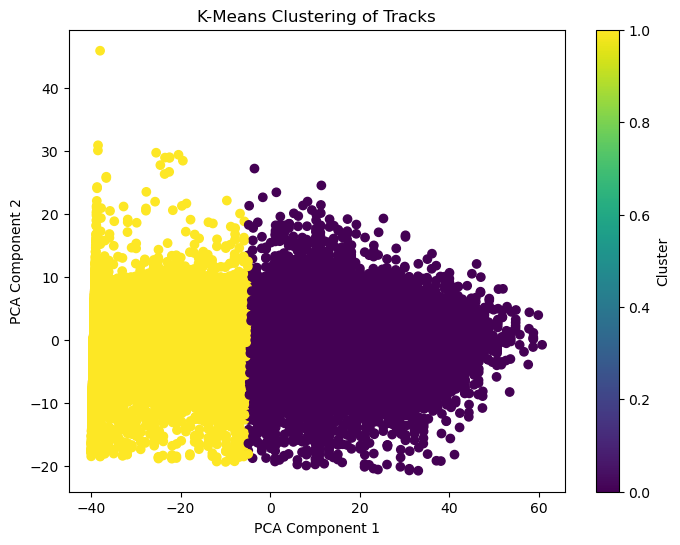

In [65]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(features_for_clustering)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
components = pca.fit_transform(features_for_clustering)
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap="viridis")
plt.title("K-Means Clustering of Tracks")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


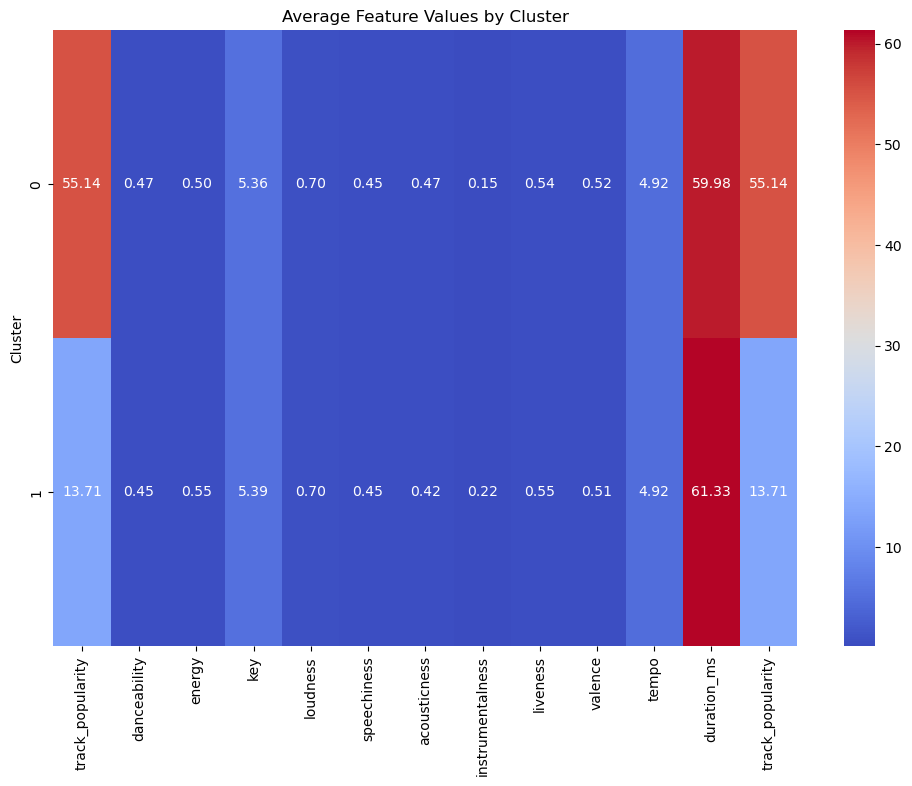

In [75]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[numeric_columns])

# Calculate mean values for each feature within each cluster
cluster_profile = df.groupby('Cluster')[numeric_columns + ['track_popularity']].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Average Feature Values by Cluster")
plt.show()

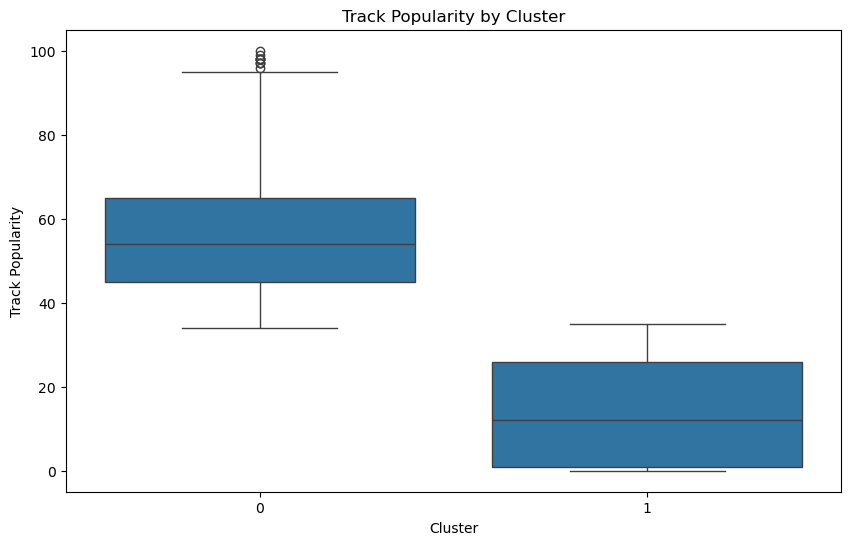

In [76]:
# Box plot to show distribution of track popularity within each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='track_popularity')
plt.title("Track Popularity by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Track Popularity")
plt.show()

#### Time-Based Trends

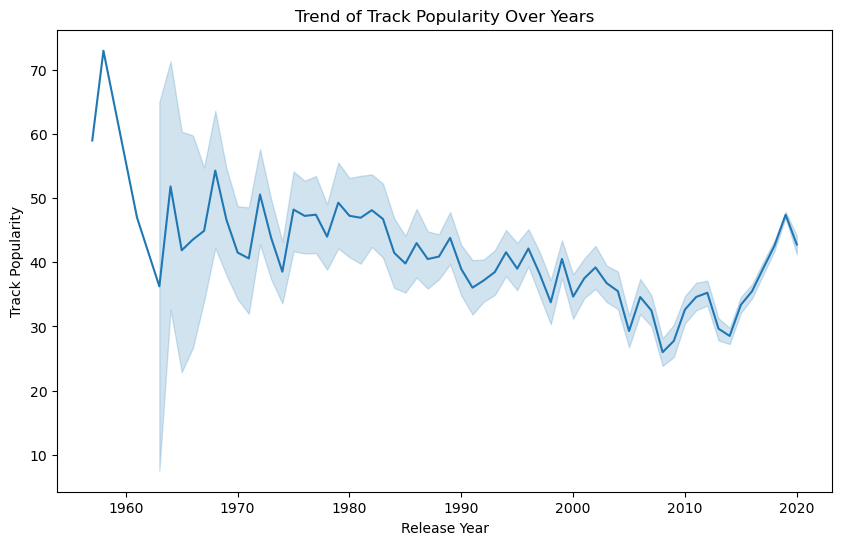

In [89]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="release_year", y="track_popularity", errorbar=('ci', 95))
plt.title("Trend of Track Popularity Over Years")
plt.xlabel("Release Year")
plt.ylabel("Track Popularity")
plt.show()


Let's find out if a specific day of month can augment our chance for our track to be popular (like christmas or summer song)

/var/folders/fk/y4nzg4p56g3_1th0bv19rx0r0000gn/T/ipykernel_82914/3405839339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=popularity_by_month, x="release_month", y="track_popularity", palette="magma")


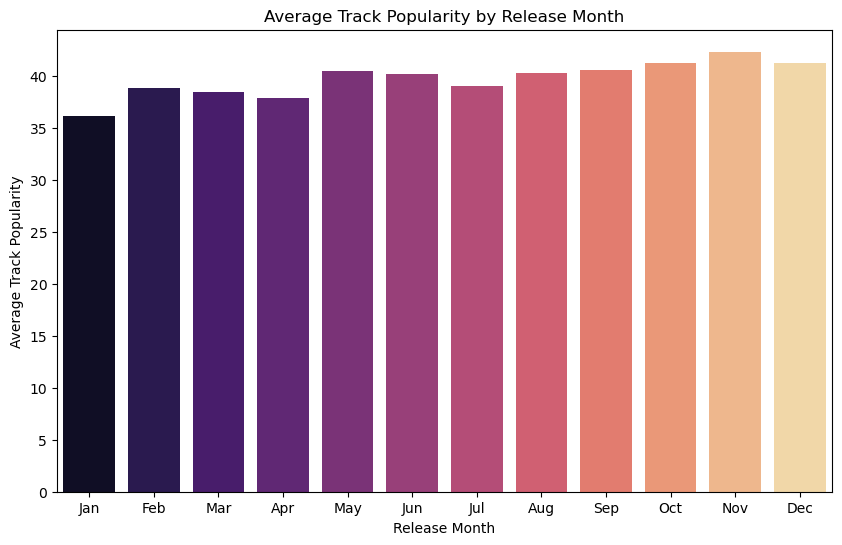

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average track popularity for each month
popularity_by_month = df.groupby('release_month')['track_popularity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=popularity_by_month, x="release_month", y="track_popularity", palette="magma")
plt.title("Average Track Popularity by Release Month")
plt.xlabel("Release Month")
plt.ylabel("Average Track Popularity")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


/var/folders/fk/y4nzg4p56g3_1th0bv19rx0r0000gn/T/ipykernel_82914/2034336463.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=popularity_by_day, x="release_day", y="track_popularity", palette="coolwarm")


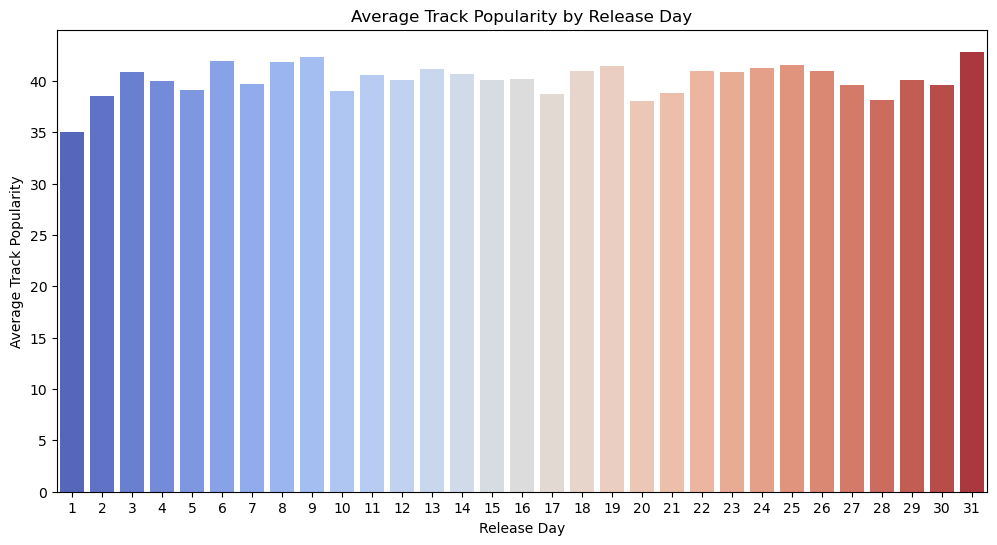

In [97]:
# Calculate the average track popularity for each day of the month
popularity_by_day = df.groupby('release_day')['track_popularity'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=popularity_by_day, x="release_day", y="track_popularity", palette="coolwarm")
plt.title("Average Track Popularity by Release Day")
plt.xlabel("Release Day")
plt.ylabel("Average Track Popularity")
plt.xticks(ticks=range(0, 31), labels=range(1, 32))  # Days from 1 to 31
plt.show()


Unfortunately, there are no clear relation ship for month or day release

In [ ]:
# Calculate average track popularity for each artist
df_artists = pd.read_csv("../data/spotify_songs.csv")
artist_popularity = df.groupby('artist_track_encoded')['track_popularity'].mean().reset_index()

# Merge with df_artists to get the artist names
df_top_artists = artist_popularity.merge(df_artists, on='artist_track_encoded')

# Sort by track popularity in descending order to find the most popular artists
df_top_artists = df_top_artists.sort_values(by='track_popularity', ascending=False)

# Display the top 10 most popular artists with names
top_artists = df_top_artists.head(10)
print("Top 10 Most Popular Artists:")
print(top_artists[['artist_name', 'track_popularity']])


Top 10 Most Popular Artists:
      artist_track_encoded  track_popularity
1161             97.000000         97.000000
1160             91.000000         91.000000
1159             87.500000         87.500000
1158             85.500000         85.500000
1157             84.333333         84.333333
1156             84.000000         84.000000
1155             83.666667         83.666667
1154             83.428571         83.428571
1153             83.000000         83.000000
1152             82.000000         82.000000


### Descriptive Statistics for Key Features

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28352.0,39.335320,23.699443,0.000000,21.000000,42.000000,58.000000,100.000000
danceability,28352.0,0.463788,0.188308,0.000000,0.325701,0.464561,0.597751,1.000000
energy,28352.0,0.521398,0.238359,0.000000,0.335241,0.521284,0.710649,1.000000
key,28352.0,5.367417,3.613743,0.000000,2.000000,6.000000,9.000000,11.000000
loudness,28352.0,0.699150,0.099062,0.000000,0.645094,0.714462,0.769362,1.000000
mode,28352.0,0.565533,0.495696,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,28352.0,0.453648,0.127350,0.000000,0.354797,0.408549,0.525214,1.000000
acousticness,28352.0,0.449806,0.248615,0.000000,0.243211,0.431212,0.639532,1.000000
instrumentalness,28352.0,0.175032,0.289067,0.000000,0.000000,0.027490,0.187693,1.000000
liveness,28352.0,0.544491,0.131413,0.000000,0.453020,0.503325,0.629961,1.000000


### Correlation between features

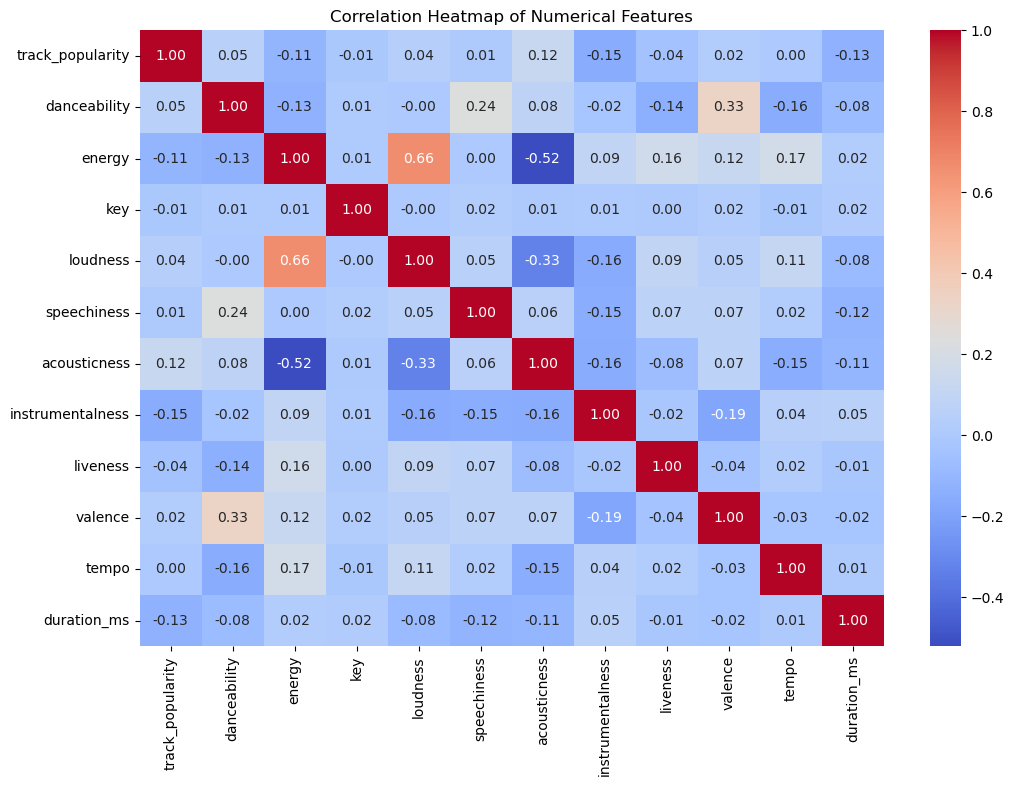

In [87]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Outlier Analysis

In [80]:
outliers = df[(np.abs(zscore(df[['loudness', 'danceability', 'energy', 'acousticness']])) > 3).any(axis=1)]
print("Number of outliers:", len(outliers))

Number of outliers: 238


In [81]:
# Dealing with outliers?

## Baseline Models

### Predicting the maximum class the target variable

In [82]:
# Like in HW4

### Linear Regression

### K-NN Classifier

In [83]:
# See HW2 for good steps on how to proceed

### Previous models?

### Comparison according to how the target variable's 0 values were handled

put a table there comparing the model performances

### Implementation Plan

1. Experiment with different feature engineering techniques, such as polynomial features or interactions.
2. Test additional models, including decision trees, random forests, and neural networks.
3. Tune hyperparameters for optimal model performance.
4. Evaluate models on RMSE and other metrics, iteratively improving results.
5. Discussion about the initial choice on how the 0 values in the target variable were handled. In the scenario where we just removed them, predicting the popularity of such songs using our final model and discussing the results.